In [3]:


import psycopg2
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks", color_codes=True)
import matplotlib
import warnings
import yellowbrick as yb


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport

warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
conn = psycopg2.connect( 
                        host = 'project.cgxhdwn5zb5t.us-east-1.rds.amazonaws.com',
                        port = 5432, 
                        user = 'postgres',
                        password = 'Admin123',
                        database = 'postgres')
cursor = conn.cursor()

In [35]:
DEC2FLOAT = psycopg2.extensions.new_type(
    psycopg2.extensions.DECIMAL.values,
    'DEC2FLOAT',
    lambda value, curs: float(value) if value is not None else None)
psycopg2.extensions.register_type(DEC2FLOAT)

In [36]:
cursor.execute('Select * from "ahshouseholdclass2"')
rows = cursor.fetchall()
col_names = []
for elt in cursor.description:
    col_names.append(elt[0])

df = pd.DataFrame(data=rows, columns=col_names )

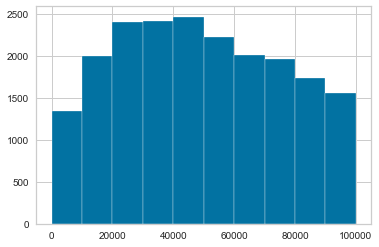

In [37]:
df['HINCP'].hist()

In [38]:
df['RATINGHS_BIN'].value_counts()

extremely satisfied    7021
satisfied              5284
not satisfied          4887
very satisfied         2916
Name: RATINGHS_BIN, dtype: int64

### Class Imbalanced

In [39]:
X = df[['HHAGE', 'HINCP', 'BATHROOMS', 'UTILAMT','PERPOVLVL',  'ELECAMT', 
        'GASAMT', 'TRASHAMT', 'WATERAMT', 'OMB13CBSA','UNITSIZE','NUMPEOPLE','STORIES', 'HHNATVTY']]

y = df['RATINGHS_BIN']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ef84390>,
      dtype=object)

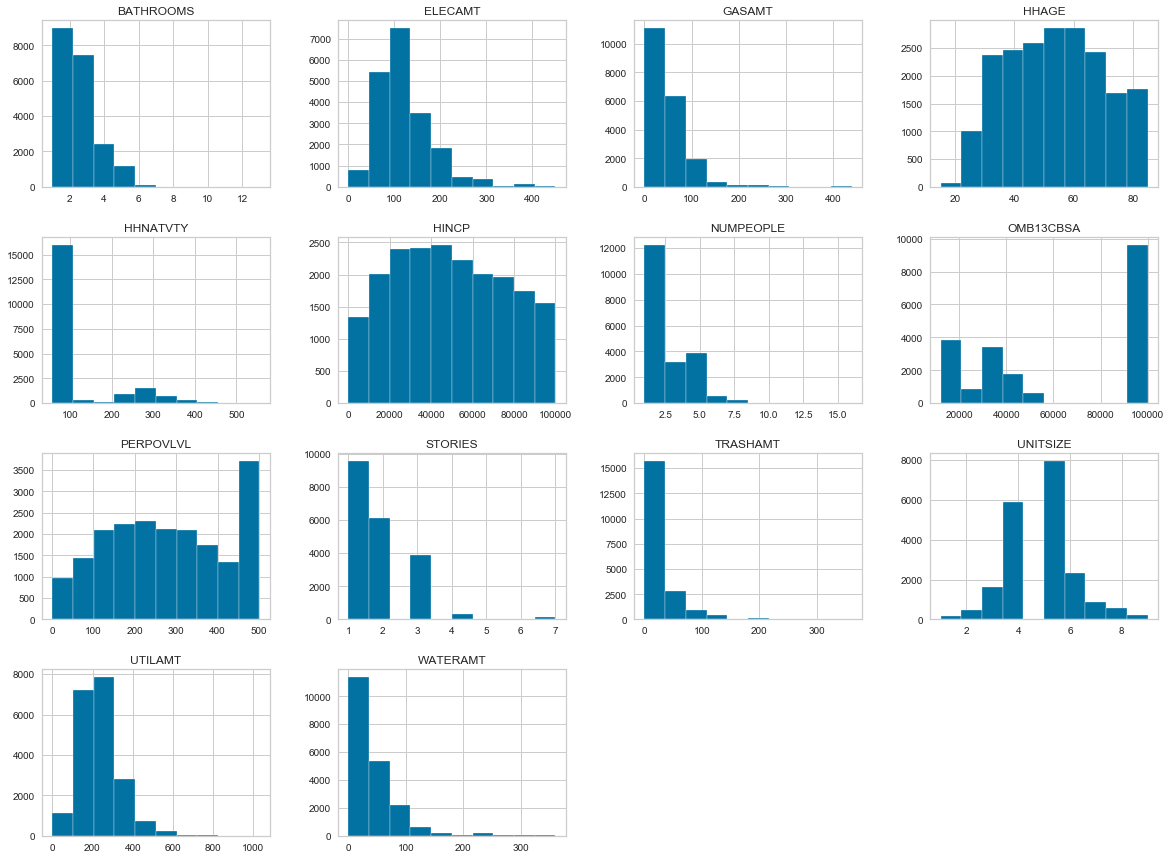

In [40]:
X.hist(figsize=(20,15))

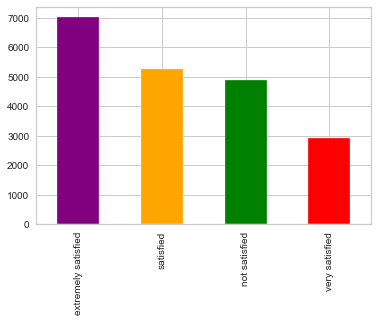

In [41]:
pd.Series(y).value_counts().plot.bar(color=['purple', 'orange', 'green', 'red'])

In [42]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 33)

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


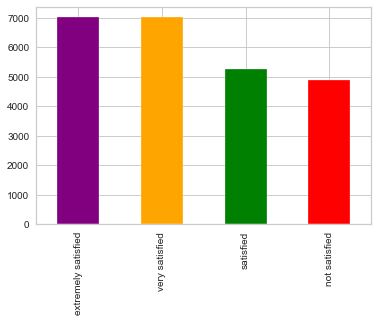

In [43]:
X_sm, y_sm = sm.fit_sample(X, y.ravel())
pd.Series(y_sm).value_counts().plot.bar(color=['purple', 'orange', 'green', 'red'])

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


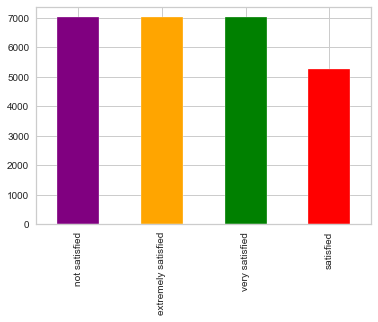

In [44]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar(color=['purple', 'orange', 'green', 'red'])

/Users/sabashaikh/anaconda2/envs/py36/lib/python3.6/site-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


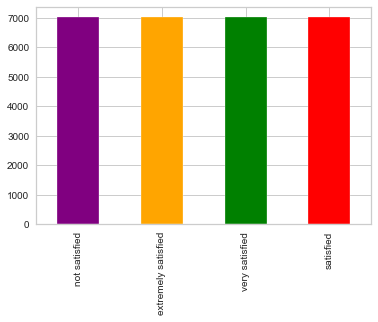

In [45]:
X_sm, y_sm = sm.fit_sample(X_sm, y_sm.ravel())
pd.Series(y_sm).value_counts().plot.bar(color=['purple', 'orange', 'green', 'red'])

Precision: It is implied as the measure of the correctly identified positive cases from all the predicted positive cases. Thus, it is useful when the costs of False Positives is high.

Recall: It is the measure of the correctly identified positive cases from all the actual positive cases. It is important when the cost of False Negatives is high.

Accuracy: One of the more obvious metrics, it is the measure of all the correctly identified cases. It is most used when all the classes are equally important.


In [46]:
# Create the train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2)

In [48]:
from sklearn import metrics
def score_model(X, y, estimator, **kwargs):
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
         ('one_hot_encoder', OneHotEncoder()), 
         ('estimator', estimator)
    ])


    model.fit(X_train, y_train.ravel(), **kwargs)  
    
    expected  = y_test
    predicted = model.predict(X_test)
    
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average='micro')))
  #  print("{} Accuracy Score: {}".format(estimator.__class__.__name__, metrics.accuracy_score(expected, predicted)))

In [50]:
models = [
    SVC(), NuSVC(), LinearSVC(), 
    SGDClassifier(), KNeighborsClassifier(), 
    LogisticRegression(), 
    ExtraTreesClassifier(),
    RandomForestClassifier(),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
]

for model in models:
    score_model(X_train, y_train.ravel(), model)

SVC: 0.2394516645896386
NuSVC: 0.35570589282535153
LinearSVC: 0.3815203845469112
SGDClassifier: 0.3834787252982019
KNeighborsClassifier: 0.3286451842620616
LogisticRegression: 0.39985757521808796
ExtraTreesClassifier: 0.3735089905643582
RandomForestClassifier: 0.3624710699661741
DecisionTreeClassifier: 0.34573615809150793
AdaBoostClassifier: 0.38775146875556343
GradientBoostingClassifier: 0.3968310486024568


## Classification Report

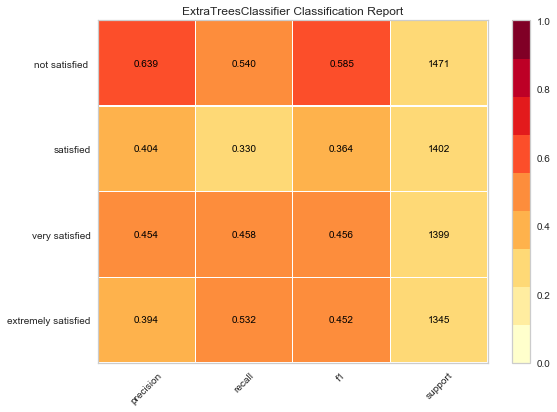

In [53]:
from yellowbrick.classifier import ClassificationReport

# Instantiate the classification model and visualizer
classes=['extremely satisfied','very satisfied','satisfied','not satisfied ']
model = ExtraTreesClassifier()
visualizer = ClassificationReport(model, classes=classes, size=(600, 420), support=True)

visualizer.fit(X_train, y_train.ravel())        # Fit the visualizer and the model
visualizer.score(X_test, y_test.ravel())        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

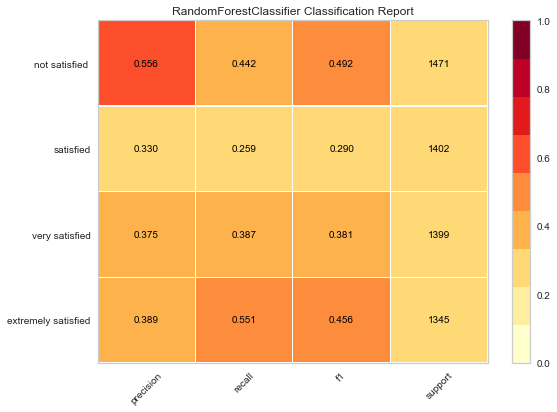

In [54]:

# Instantiate the classification model and visualizer
classes=['extremely satisfied','very satisfied','satisfied','not satisfied ']
model = RandomForestClassifier()
visualizer = ClassificationReport(model, classes=classes, size=(600, 420), support=True)

visualizer.fit(X_train, y_train.ravel())        # Fit the visualizer and the model
visualizer.score(X_test, y_test.ravel())        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

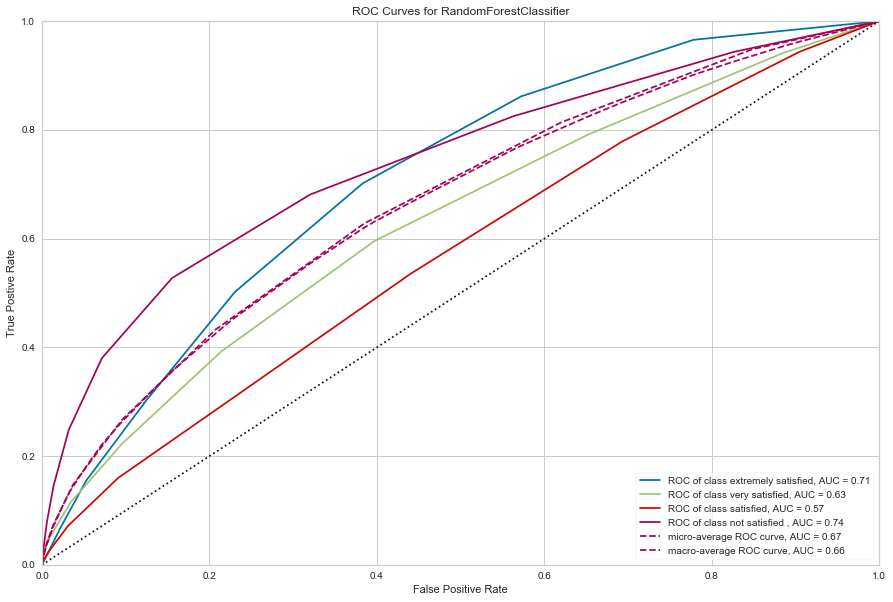

In [55]:
from yellowbrick.classifier import ROCAUC
classes=['extremely satisfied','very satisfied','satisfied','not satisfied ']

visualizer = ROCAUC(
    RandomForestClassifier(), classes=classes, size=(1080, 720)
)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Draw the data

### Confusion Matrixs


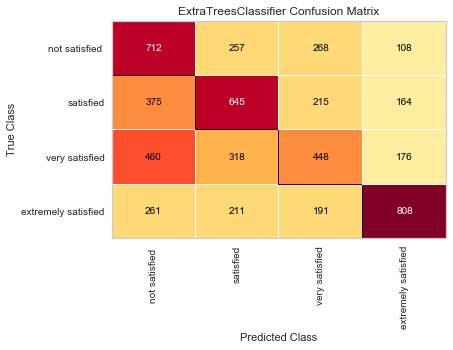

In [58]:
from yellowbrick.classifier import ConfusionMatrix
model = ExtraTreesClassifier()

cm = ConfusionMatrix(model, classes=['not satisfied ','satisfied','very satisfied','extremely satisfied'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train.ravel())

cm.score(X_test, y_test.ravel())

cm.show()

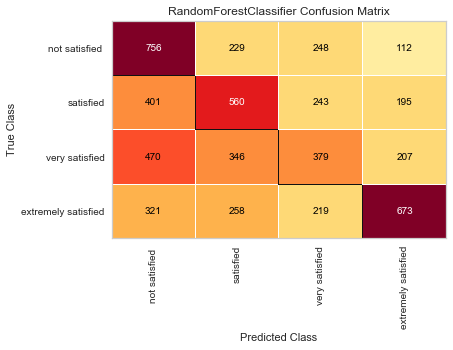

In [60]:
model = RandomForestClassifier()

cm = ConfusionMatrix(model, classes=['not satisfied ','satisfied','very satisfied','extremely satisfied'])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train.ravel())

cm.score(X_test, y_test.ravel())

cm.show()

### Cross Validation

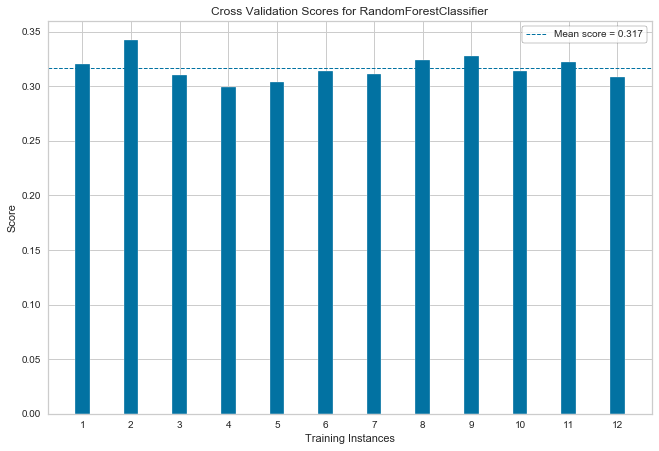

In [61]:

from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores


# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model = RandomForestClassifier()
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(780, 520)
)

visualizer.fit(X, y)
visualizer.show()

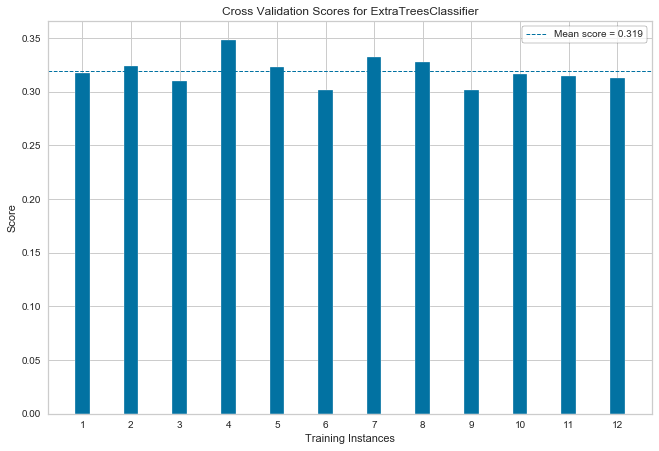

In [62]:
#With Class Balanced

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import CVScores


# Create a cross-validation strategy
cv = StratifiedKFold(n_splits=12, random_state=42)

# Instantiate the classification model and visualizer
model =  ExtraTreesClassifier()
visualizer = CVScores(
    model, cv=cv, scoring='f1_weighted', size=(780, 520)
)

visualizer.fit(X, y)
visualizer.show()

### GridSearchCV

In [ ]:
RandomForestClassifier().get_params()

In [ ]:

from sklearn.model_selection import GridSearchCV
model = RandomForestClassifier()

# TODO:  Create a dictionary with the Ridge parameter options
parameters = {
    'n_estimators': [200, 300],
    'max_features': ['auto', 'sqrt','log2'],
    'min_samples_split':[2,4,6],
    'n_jobs':[2,4]
}

clf = GridSearchCV(model, parameters, cv=5)
clf.fit(X_train, y_train)

print('If we change our parameters to: {}'.format(clf.best_params_))
print(clf.best_estimator_)

In [ ]:
models = [
  
    ExtraTreesClassifier(n_estimators=100, max_features='log2', n_jobs=2, random_state=42),
    AdaBoostClassifier(learning_rate=0.7,n_estimators=200),
    GradientBoostingClassifier(n_estimators=100, learning_rate=.5,max_depth=4),
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, 
                        min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
  
]

for model in models:
    score_model(X_train, y_train.ravel(), model)